# Useful Links

Guide to tf.graphs, tf.data_types, tf.tensorboard and tf.saver:

https://www.easy-tensorflow.com/tf-tutorials/basics/graph-and-session

Guide to adversarial examples:

https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/

Explanation of reuse property:

https://medium.com/@hideyuki/what-does-variable-reuse-mean-in-tensorflow-40e86535026b

Guide to Pillow library:

https://pillow.readthedocs.io/en/latest/

Note: do not run "init_global_variables()" if planning to restore  

### Import necessaary libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Useful functions

### Inception architecture 
(not for direct use)

In [2]:
# unfortunately, with simple session it is prohibited to use such functions;
# this still can be used for references or interactive sessions

# while initiaizing the model in tensorflow it is necessary to specify
# the input. The reason is how graphs work in tf. Input images should 
# be scaled to the range of [-1, 1] and have format (num_images, 299, 299, 3)
def inception(input_images):
    # download default values from the lib in the form of dictionary
    # keys include: activation_funcntion    (ReLU)
    #               decay                   (0.9997)
    #               normilizer              (batch_norm)
    #               etc.
    # keys you want to change you can type inside (*)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    
    # the following is a context manager. That is, within the space specified
    # with tf.contrib.framework.arg_scope(dict) values stored in  the dict are
    # automatically passed to all functions. That is, when we declare inception_v3()
    # instead of specifying each argument manually in a way inc_v3(decay = [dict['decay']]),
    # we have them automatically set.
    with tf.contrib.framework.arg_scope(arg_scope):
        
        # this function creates architecture (not weights) of inception_v3. It returns: 
        # tf_logits  - a vecotr of raw (not scaled to [0, 1]) scores for all of the classes
        #     of the net (i.e. its output tensor) you can apply softmax here to get probabilities
        #     or just get amax to find predicted class                                                 
        # end_points - a dictionary containing output tensors of important layers of the model
        tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(input_images,
                                                                            num_classes=1001,   # default 
                                                                            is_training=False)
        
        # logits is a tensor of shape (?, 1001). We are interested only in teh second 
        # deimension of the tensor (because first is background class)
        tf_logits = tf_logits[:,1:]
        
        # get probabilities
        probs = tf.nn.softmax(tf_logits) 
    
        return probs

### Preprocess the image

In [3]:
# Input images should be scaled to the range of [-1, 1] and have format (num_images, 299, 299, 3)
# this function takes as an input *.jpg image (because *.png-s actually have 4-dims),
# crops it to the size 300x300, and convert to tensor. For convenience, it returns both scaled tensor
# and preprocessed image.
def preprocessing(raw_pillow_image):

    # scale the image in a way that maps its smaller dimension to the length of 300
    wide = raw_pillow_image.width > raw_pillow_image.height
    if wide:
        new_width = int(raw_pillow_image.width * 299 / raw_pillow_image.height)
        new_height = 299
    else:
        new_width = 299
        new_height = int(raw_pillow_image.height * 299 / raw_pillow_image.width)

    # catually scale image 
    raw_pillow_image = raw_pillow_image.resize((new_width, new_height))
    
    # crop exceeding dimension
    raw_pillow_image = raw_pillow_image.crop((0, 0, 299, 299))
    
    # scale to [0, 1]
    pillow_image = (np.asarray(raw_pillow_image) / 255.0).astype(np.float32)
    
    # add dimension in the start (becaus3e we have only one image) and convert to tensor 
    tf_image = tf.multiply(tf.subtract(tf.expand_dims(pillow_image, 0), 0.5), 2.0)
    
    return pillow_image, tf_image

### Plot the image

In [4]:
def show_image(img):
    imgplot = plt.imshow(img)
    plt.show()

# Workspace

### Load labels

In [5]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

### Choose an image

In [6]:
img1_path = './ImageNet/467863966_a01cbd9d90.jpg'
img2_path = './ImageNet/857502810_4313e2fbd4.jpg'
img3_path = './ImageNet/81-yKbVND-L.png'
img4_path = ''
img5_path = './ImageNet/EJxGm89VUAERo8e.jpg'
img6_path = './ImageNet/flowers.jpg'

my_raw_pillow_image = PIL.Image.open(img2_path) 

### Classification cell

In [50]:
# Allows not to reboot kernel on each initialization
tf.reset_default_graph()   



# declare variable and pass initializer function to it
my_tf_image = tf.get_variable(name="my_img", 
                              initializer=preprocessing(my_raw_pillow_image)[1])



# download default values from the lib in the form of dictionary
# keys include: activation_funcntion    (ReLU)
#               decay                   (0.9997)
#               normilizer              (batch_norm)
#               etc.
# keys you want to change you can type inside (*)
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)

# the following is a context manager. That is, within the space specified
# with tf.contrib.framework.arg_scope(dict) values stored in  the dict are
# automatically passed to all functions. That is, when we declare inception_v3()
# instead of specifying each argument manually in a way inc_v3(decay = [dict['decay']]),
# we have them automatically set.
with tf.contrib.framework.arg_scope(arg_scope):

    # this function creates architecture (not weights) of inception_v3. It returns: 
    # tf_logits  - a vecotr of raw (not scaled to [0, 1]) scores for all of the classes
    #     of the net (i.e. its output tensor) you can apply softmax here to get probabilities
    #     or just get amax to find predicted class                                                 
    # end_points - a dictionary containing output tensors of important layers of the model
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(my_tf_image,
                                                                        num_classes=1001,   # default (somehow),
                                                                        is_training=False,  # but there are only 
                                                                        reuse = False)      # 1000 classes
                                                                        
    # logits is a tensor of shape (?, 1001). We are interested only in teh second 
    # deimension of the tensor (because first is background class)
    tf_logits = tf_logits[:,1:]

    # get probabilities
    probs = tf.nn.softmax(tf_logits) 



# declare variables to restore with saver; remember, that we want to restore
# only inception v3 variables and not our image; also note, that 
# tf.global_variables() returns all global variables declared after reset.
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore vars when called
saver = tf.train.Saver(restore_vars)

# add an operation to initialize input
init_my_tf_image = tf.variables_initializer([my_tf_image])

INFO:tensorflow:Scale of 0 disables regularizer.


### Construct naive adversarial patch

### Save current graph

In [ ]:
# use this cell if you need to save graph to corresponding folder 
writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

# Run learning 

In [51]:
with tf.Session() as sess:
    saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    # run the variable initializer operation
    sess.run(init_my_tf_image)    
    
    # now let's evaluate their value
    my_probs = sess.run(probs)
    

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt


# Analyze

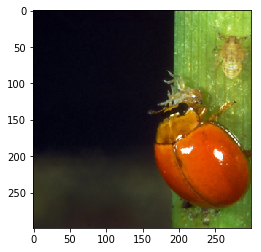

ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle


In [53]:
my_pillow_image = preprocessing(my_raw_pillow_image)[0]

show_image(my_pillow_image)
#print(len(my_probs[0]))
#print(my_probs[0])
#print(np.where(my_probs[0] == np.amax(my_probs[0])))
print(imagenet_labels[np.where(my_probs[0] == np.amax(my_probs[0]))[0][0]] )